In [1]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
# import ppscore as pps # ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.1.2 which is incompatible.

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.graphics.gofplots import qqplot

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics


from housing_crawler.analysis.ads_table_processing import get_processed_ads_table

%load_ext autoreload
%autoreload 2

# Prepare data

## Obtain data for WGs

In [2]:
df_original = get_processed_ads_table()


===> Loaded ads_OSM.csv locally


/home/carlo/code/chvieira2/housing_crawler/housing_crawler/utils.py:35: DtypeWarning: Columns (29,31,33,34,35,37,42,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path)


In [3]:
ads_feat_df = df_original[df_original['details_searched']==1]
# ads_feat_df = ads_feat_df[ads_feat_df['city'].isin(['Berlin', 'München', 'Hamburg', 'Stuttgart', 'Köln', 'Münster', 'Leipzig', 'Frankfurt am Main'])]
ads_feat_df = ads_feat_df.set_index('id')

## Remove duplicates if exist

In [4]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

## Filter data accordingly

In [5]:
# Filter only ads that have been searched for details (search added from august on)
df_filtered = ads_feat_df.copy()
df_filtered = df_filtered[df_filtered['type_offer_simple']=='WG']
df_filtered = df_filtered[df_filtered['km_to_centroid'].notna()]
df_filtered.shape

(6595, 142)

## Drop columns I won't use for modelling

In [6]:
# Drop unnecessary columns
df_filtered = df_filtered[[
#         'url',
        'commercial_landlord',
#         'title',
#         'type_offer_simple',
        'size_sqm',
#         'home_total_size',
#         'available_rooms',
        'capacity',
#         'available_spots_wg',
    
#         'address',
        'city',
#         'zip_code',
#         'latitude',
#         'longitude',
    
#         'published_on',
#         'published_at',
#         'day_of_week_publication',
#         'available_from',
#         'available_to',
        'days_available',
        'rental_length_term',
#         'sin_published_at',
#         'cos_published_at',
#         'sin_day_week_int',
#         'cos_day_week_int',
    
#         'details_searched',
#         'crawler',
    
# Values
        'price_euros',    
#         'cold_rent_euros',
#         'mandatory_costs_euros',
#         'extra_costs_euros',
#         'deposit',
        'transfer_costs_euros',
#         'price_per_sqm',

# Flatmates
        'male_flatmates',
        'female_flatmates',
        'diverse_flatmates',
        'min_age_flatmates',
        'max_age_flatmates',
    
# Person searched
        'gender_searched',
        'min_age_searched',
        'max_age_searched',
        'age_category_searched',
    
# Details
    
        'schufa_needed',
#         'wg_possible',
    
#         'smoking',
        'smoking_numerical',
        'building_type',
        'building_floor',
#         'furniture',
        'furniture_numerical',
#         'kitchen',
        'kitchen_numerical',
        'heating',
        'public_transport_distance',
        'parking',
    
#         'construction_year',
#         'energy_certificate',
#         'energy_usage',
#         'energy_efficiency_class',
#         'heating_energy_source',
    
        'tv_kabel',
        'tv_satellit',
    
#         'toilet',
        'shower_type_badewanne',
        'shower_type_dusche',
    
        'floor_type_dielen',
        'floor_type_parkett',
        'floor_type_laminat',
        'floor_type_teppich',
        'floor_type_fliesen',
        'floor_type_pvc',
        'floor_type_fußbodenheizung',
    
        'extras_waschmaschine',
        'extras_spuelmaschine',
        'extras_terrasse',
        'extras_balkon',
        'extras_garten',
        'extras_gartenmitbenutzung',
        'extras_keller',
        'extras_aufzug',
        'extras_haustiere',
        'extras_fahrradkeller',
        'extras_dachboden',
    
# WG only
        'number_languages',
        'languages_deutsch',
        'languages_englisch',
    
        'wg_type_studenten',
        'wg_type_keine_zweck',
        'wg_type_maenner',
        'wg_type_business',
        'wg_type_wohnheim',
        'wg_type_vegetarisch_vegan',
        'wg_type_alleinerziehende',
        'wg_type_funktionale',
        'wg_type_berufstaetigen',
        'wg_type_gemischte',
        'wg_type_mit_kindern',
        'wg_type_verbindung',
        'wg_type_lgbtqia',
        'wg_type_senioren',
        'wg_type_inklusive',
        'wg_type_wg_neugruendung',
    
        'internet_speed',
        'internet_dsl',
        'internet_wlan',
        'internet_flatrate',
    

# Geographical
        'km_to_centroid',
        'sin_degrees_to_centroid',
        'cos_degrees_to_centroid',

# OSM features
        'comfort_leisure_spots',
        'comfort_warehouse',
        'activities_education',
        'mobility_public_transport_bus',
        'activities_economic',
        'comfort_industrial',
        'activities_goverment',
        'social_life_eating',
        'comfort_comfort_spots',
        'social_life_culture',
        'activities_supermarket',
#         'activities_public_service',
        'social_life_community',
        'comfort_leisure_mass',
        'activities_educational',
        'mobility_street_secondary',
        'mobility_public_transport_rail',
        'activities_retail',
        'social_life_night_life',
        'comfort_green_natural',
        'comfort_railway',
        'mobility_bike_infraestructure',
#         'comfort_green_forests',
        'mobility_street_primary',
        'comfort_lakes',
#         'activities_health_regional',
        'activities_health_local',
        'comfort_green_space',
        'comfort_rivers',
        'activities_post',
        'comfort_green_parks',
        'comfort_street_motorway'
        ]]

## Define numerical and categorical columns

In [7]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df_filtered)
categorical_columns = categorical_columns_selector(df_filtered)
# categorical_columns.remove('city')

# Removing outliers

In [8]:
### List of columns with manually inserted values that would possibly contain outliers and/werid values

manually_inserted_values_columns = [
    'price_euros',
    'size_sqm',
#     'cold_rent_euros',
#     'mandatory_costs_euros',
#     'extra_costs_euros',
#     'deposit',
#     'home_total_size',
    'public_transport_distance',
    'transfer_costs_euros',
    'min_age_flatmates',
    'max_age_flatmates',
    'min_age_searched',
    'max_age_searched',
#     'construction_year',
#     'energy_usage'
]

'max_age_flatmates'

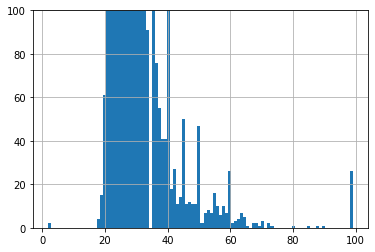

In [9]:
### Manually look into the variable distribution to identify outliers
col = manually_inserted_values_columns[5]
df_filtered[col].hist(bins = 100);
# df_filtered[[col]].boxplot()
# plt.xlim(0,300)
plt.ylim(0,100);
col

In [10]:
#### Manage identified outliers
# max_age_flatmates
# There are some ads with really extreme energy usage values (<18 or >80). These were removed for modelling
df_filtered['max_age_flatmates'] = [np.nan if (value!=value) or value < 18 or value >80 else value for value in list(df_filtered['max_age_flatmates'])]

# Dealing with NAs

In [11]:
df_imputted = df_filtered.copy()

In [12]:
# Percentage missing values per column before imputting
(df_imputted.isnull().sum().sort_values(ascending=False)/len(df_imputted)*100)[0:10]

internet_speed               69.461713
transfer_costs_euros         65.489007
heating                      56.830933
parking                      41.592115
max_age_flatmates            29.825625
min_age_flatmates            24.109174
building_type                20.697498
public_transport_distance    11.630023
building_floor               10.750569
km_to_centroid                0.000000
dtype: float64

## Imputting numerical columns

'internet_speed'

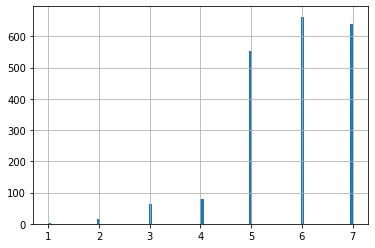

In [13]:
num_cols_imputing = ['internet_speed',
                     'max_age_flatmates','min_age_flatmates',
                    'cos_published_at', 'sin_published_at',
                    'public_transport_distance','building_floor']

col = num_cols_imputing[0]
df_imputted[col].hist(bins = 100);
# df_filtered[[col]].boxplot()
# plt.xlim(0,300)
# plt.ylim(0,100);
col

In [14]:
num_cols_imputing_mean = ['min_age_flatmates', 'max_age_flatmates']
num_cols_imputing_median = ['internet_speed', 'public_transport_distance', 'building_floor'] 

num_imputer_mean = SimpleImputer(strategy="mean") # Instantiate a SimpleImputer object with your strategy of choice
num_imputer_median = SimpleImputer(strategy="median") # Instantiate a SimpleImputer object with your strategy of choice

num_imputer_mean.fit(df_imputted[num_cols_imputing_mean]) # Call the "fit" method on the object
num_imputer_median.fit(df_imputted[num_cols_imputing_median]) # Call the "fit" method on the object

df_imputted[num_cols_imputing_mean] = num_imputer_mean.transform(df_imputted[num_cols_imputing_mean]) # Call the "transform" method on the object
df_imputted[num_cols_imputing_median] = num_imputer_median.transform(df_imputted[num_cols_imputing_median]) # Call the "transform" method on the object

num_imputer_mean.statistics_,  num_imputer_median.statistics_# The mean is stored in the transformer's memory

(array([24.17582418, 29.85328436]), array([6., 3., 2.]))

In [15]:
# Percentage missing values per column after imputing
(df_imputted.isnull().sum().sort_values(ascending=False)/len(df_imputted)*100)[0:10]

transfer_costs_euros       65.489007
heating                    56.830933
parking                    41.592115
building_type              20.697498
commercial_landlord         0.000000
internet_dsl                0.000000
activities_education        0.000000
comfort_warehouse           0.000000
comfort_leisure_spots       0.000000
cos_degrees_to_centroid     0.000000
dtype: float64

## Imputting categorical columns

In [16]:
# For some unknown reason imputting for transfer_costs_euros doesn't work, so I manually imput 0 values here for transfer_costs_euros without a answer
features_noanswer = ['transfer_costs_euros']

noanswer_imputer = SimpleImputer(strategy="constant", fill_value=0) 

noanswer_imputer.fit(df_imputted[features_noanswer])

df_imputted[features_noanswer] = noanswer_imputer.transform(df_imputted[features_noanswer])

In [17]:
# Features in which NaN values represent something
features_noanswer = ['heating', 'parking', 'building_type']

noanswer_imputer = SimpleImputer(strategy="constant", fill_value="no_answer") 

noanswer_imputer.fit(df_imputted[features_noanswer])

df_imputted[features_noanswer] = noanswer_imputer.transform(df_imputted[features_noanswer])

In [18]:
# Percentage missing values per column after imputing
(df_imputted.isnull().sum().sort_values(ascending=False)/len(df_imputted)*100)[0:10]

commercial_landlord        0.0
wg_type_inklusive          0.0
comfort_warehouse          0.0
comfort_leisure_spots      0.0
cos_degrees_to_centroid    0.0
sin_degrees_to_centroid    0.0
km_to_centroid             0.0
internet_flatrate          0.0
internet_wlan              0.0
internet_dsl               0.0
dtype: float64

# Scaling columns

In [19]:
df_scaled = df_imputted.copy()

## Find colums for each type of scaling

In [20]:
features_OSM = [
                'comfort_leisure_spots',
                'comfort_warehouse',
                'activities_education',
                'mobility_public_transport_bus',
                'activities_economic',
                'comfort_industrial',
                'activities_goverment',
                'social_life_eating',
                'comfort_comfort_spots',
                'social_life_culture',
                'activities_supermarket',
#                 'activities_public_service',
                'social_life_community',
                'comfort_leisure_mass',
                'activities_educational',
                'mobility_street_secondary',
                'mobility_public_transport_rail',
                'activities_retail',
                'social_life_night_life',
                'comfort_green_natural',
                'comfort_railway',
                'mobility_bike_infraestructure',
#                 'comfort_green_forests',
                'mobility_street_primary',
                'comfort_lakes',
#                 'activities_health_regional',
                'activities_health_local',
                'comfort_green_space',
                'comfort_rivers',
                'activities_post',
                'comfort_green_parks',
                'comfort_street_motorway']

In [21]:
continuous_num_cols = ['size_sqm', 'public_transport_distance', 'km_to_centroid'] #+ features_OSM

In [22]:
# for numerical_feature in continuous_num_cols:
#     fig, ax = plt.subplots(1,3, figsize = (15,5))
    
#     ax[0].set_title(f"Distribution of {numerical_feature}")
#     sns.histplot(x = df_scaled[numerical_feature], kde = True, ax = ax[0])
    
#     ax[1].set_title(f"Boxplot of {numerical_feature}")
#     sns.boxplot(x = df_scaled[numerical_feature], ax = ax[1])
    
#     ax[2].set_title(f"QQplot of {numerical_feature}")
#     qqplot(df_scaled[numerical_feature], line='s', ax = ax[2])

['size_sqm', 'public_transport_distance', 'km_to_centroid']


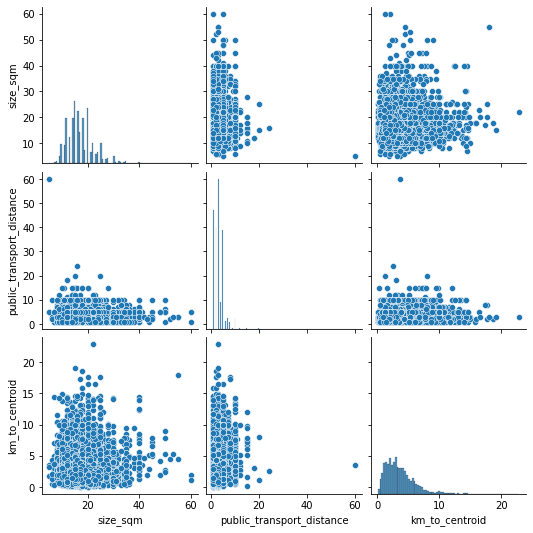

In [23]:
cols = continuous_num_cols#numerical_columns[0:3]
sns.pairplot(df_scaled.reset_index(), vars=cols);
print(cols)

In [24]:
cols_minmax_scaler = ['capacity', 'transfer_costs_euros', 
                      'male_flatmates', 'female_flatmates', 'diverse_flatmates',
                      'min_age_flatmates', 'max_age_flatmates', 'min_age_searched', 'max_age_searched',
                      'smoking_numerical', 'building_floor', 'furniture_numerical', 'kitchen_numerical',
                      'number_languages', 'internet_speed', 'sin_degrees_to_centroid', 'cos_degrees_to_centroid'] + features_OSM
cols_standard_scaler = ['size_sqm', 'km_to_centroid']
cols_robust_scaler = ['public_transport_distance']

## Scaling features

In [25]:
# Instanciate MinMaxScaler
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# Fit scaler to data
minmax_scaler.fit(df_scaled[cols_minmax_scaler])
standard_scaler.fit(df_scaled[cols_standard_scaler])
robust_scaler.fit(df_scaled[cols_robust_scaler])

# Use scaler to transform data
df_scaled[cols_minmax_scaler] = minmax_scaler.transform(df_scaled[cols_minmax_scaler])
df_scaled[cols_standard_scaler] = standard_scaler.transform(df_scaled[cols_standard_scaler])
df_scaled[cols_robust_scaler] = robust_scaler.transform(df_scaled[cols_robust_scaler])

In [26]:
df_scaled.describe()

,commercial_landlord,size_sqm,capacity,days_available,price_euros,transfer_costs_euros,male_flatmates,female_flatmates,diverse_flatmates,min_age_flatmates,max_age_flatmates,min_age_searched,max_age_searched,schufa_needed,smoking_numerical,building_floor,furniture_numerical,kitchen_numerical,public_transport_distance,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,number_languages,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,internet_speed,internet_dsl,internet_wlan,internet_flatrate,km_to_centroid,sin_degrees_to_centroid,cos_degrees_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway
count,6595.00000,6.595000e+03,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6.595000e+03,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6.595000e+03,6595.000000,6595.000000,6595.000000,6.595000e+03,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000,6595.000000
mean,0.00652,-2.542655e-16,0.087592,479.055345,477.982866,0.009424,0.106124,0.066812,0.001223,0.293365,0.191182,0.256243,0.503181,0.086732,0.199090,0.426438,0.538969,0.003904,0.058125,0.177559,0.049128,0.264139,0.310387,0.146171,0.217286,0.283397,0.055951,0.193632,0.071114,0.033662,0.741471,0.545110,0.104625,0.420773,0.259742,0.184230,0.466869,0.107202,0.070356,0.317362,0.000152,0.109492,0.844579,0.724943,0.486581,0.406520,0.011069,0.023199,0.005459,0.050038,0.004397,0.013040,0.358150,0.386657,0.008340,0.005610,0.105080,0.001516,0.007733,0.022745,0.825095,0.374071,0.720243,0.209856,2.068601e-16,0.512585,0.448265,0.055361,0.019617,0.035812,0.125271,0.085026,0.032355,2.121683e-02,0.124542,0.036352,0.075340,1.747866e-02,0.116753,0.070725,0.098421,0.125828,0.130372,0.047771,0.061662,0.011254,0.027615,0.043337,0.098805,0.032650,0.068416,0.024163,0.025374,0.193496,0.033353,0.007109
std,0.08049,1.000076e+00,0.113255,324.567632,171.121011,0.043384,0.115981,0.074684,0.016765,0.068706,0.104665,0.195824,0.400

# OneHot encoding

In [27]:
ohe = OneHotEncoder(sparse=False, drop='if_binary', categories='auto')
feature_arr = ohe.fit_transform(df_filtered[categorical_columns])

## Get name of new columns and create new dataframe
feature_labels = ohe.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)

In [28]:
# Give correct indexes to feature table. Needed for concatenating
features.index = df_filtered.index
## Add new columns to dataframe
df_processed = pd.concat([df_scaled, features], axis = 1).drop(columns=categorical_columns)
df_processed.columns = [col.lower().replace(' ', '_').replace('ä','ae').replace('ö','oe').replace('ü','ue').replace('ß','ss') for col in df_processed.columns]

In [29]:
df_processed.shape

(6595, 167)

# Minimize features

In [30]:
df_minimal = df_processed.copy()

In [31]:
df_minimal.shape

(6595, 167)

In [32]:
# Define columns to be tested. Don't test the target, commercial_landlord and 'city'
cols_to_search = [col for col in df_minimal.columns if col not in ['price_euros', 'commercial_landlord']]
cols_to_search = [col for col in cols_to_search if not col.startswith('city_')]

cols_exclude = []
for col in cols_to_search:
    # How many times the most frequent val exists
    most_freq_count = list(df_minimal[col].value_counts())[0]
    
    if most_freq_count > len(df_minimal)*0.99:
        cols_exclude.append(col)

        
# Exclude all columns (except cities) with >99% of the same value (0) as it contains very little information
df_minimal = df_minimal.drop(columns=cols_exclude)
df_minimal.shape

(6595, 148)

In [33]:
cols_exclude

['kitchen_numerical',
 'extras_dachboden',
 'wg_type_wohnheim',
 'wg_type_alleinerziehende',
 'wg_type_mit_kindern',
 'wg_type_verbindung',
 'wg_type_senioren',
 'wg_type_inklusive',
 'gender_searched_divers',
 'age_category_searched_20_20',
 'age_category_searched_40_100',
 'age_category_searched_40_40',
 'age_category_searched_40_60',
 'age_category_searched_60_100',
 'age_category_searched_60_60',
 'building_type_plattenbau',
 'heating_kohleofen',
 'heating_nachtspeicherofen',
 'heating_ofenheizung']

# Colinearity

In [34]:
df_analysed = df_minimal.copy()

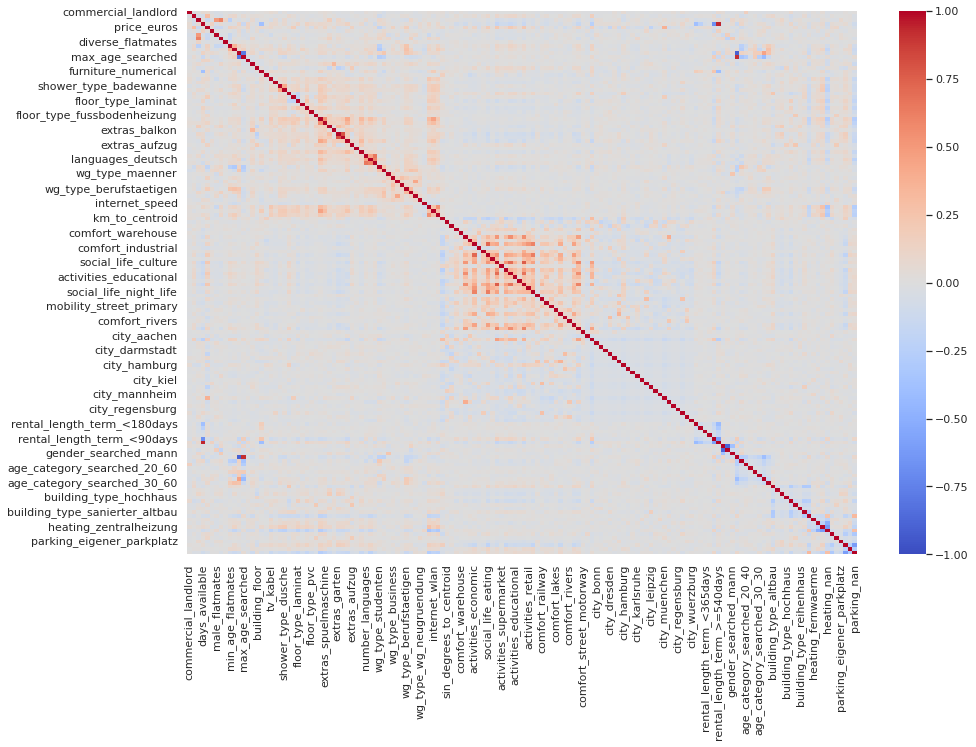

In [35]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

data_corr = df_minimal.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-1, vmax=1);

In [36]:
df_analysed = df_analysed.drop(columns=['age_category_searched_20_100',
                                        'extras_gartenmitbenutzung', 'gender_searched_egal'])

In [37]:
data_corr = df_analysed.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
# corr_df['correlation'] = -corr_df['correlation'] # Invert signal to see negative correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
551,days_available,rental_length_term_>=540days,0.943199
16823,rental_length_term_>=540days,days_available,0.943199
10652,mobility_public_transport_rail,social_life_culture,0.760768
9788,social_life_culture,mobility_public_transport_rail,0.760768
9055,activities_economic,social_life_eating,0.725153
9487,social_life_eating,activities_economic,0.725153
9785,social_life_culture,comfort_leisure_mass,0.688397
10217,comfort_leisure_mass,social_life_culture,0.688397
10223,comfort_leisure_mass,mobility_public_transport_rail,0.669162
10655,mobility_public_transport_rail,comfort_leisure_mass,0.669162


In [38]:
# These are columns that are always removed, so I'm removing them prematurely to reduce the calculation time
df_analysed = df_analysed.drop(columns = ['internet_speed',
                    'max_age_searched',
#                     'rental_length_term_>=540days',
                    'days_available',
                    'min_age_flatmates',
                    'min_age_searched'
                  ])

In [39]:
# Automatized Variation Inflation Factor (VIF) analysis
# Removing columns must be done one at a time because they influence each others VIF results

remove = True
cols_to_exclude = []
while remove:
    df = pd.DataFrame()
    
    selected_columns = ['price_euros'] # Ignore the targer column
    selected_columns = [col for col in df_analysed.columns.to_list() if col not in selected_columns]

    df["features"] = selected_columns

    df["vif_index"] = [vif(df_analysed[selected_columns].values, i) for i in range(df_analysed[selected_columns].shape[1])]

    df = round(df.sort_values(by="vif_index", ascending = False),2)
    
    df = df.head(1)

    if float(df.vif_index) >= 10:
        print(df)
        cols_to_exclude = cols_to_exclude + df.features.to_list()
        df_analysed = df_analysed.drop(columns = df.features)
    else:
        remove = False

cols_to_exclude

/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/s

        features  vif_index
138  parking_nan        inf


/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/home/carlo/.pyenv/versions/3.8.12/envs/housing_crawlerenv/lib/python3.8/site-packages/statsmodels/s

            features  vif_index
101  city_regensburg        inf
                         features  vif_index
109  rental_length_term_>=540days     272.88
        features  vif_index
130  heating_nan      47.35
                 features  vif_index
118  building_type_altbau      18.27
             features  vif_index
34  languages_deutsch      11.69
       features  vif_index
81  city_berlin      10.04


['parking_nan',
 'city_regensburg',
 'rental_length_term_>=540days',
 'heating_nan',
 'building_type_altbau',
 'languages_deutsch',
 'city_berlin']

In [40]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()


selected_columns = [col for col in df_analysed.columns.to_list() if col not in ['price_euros']]

df["features"] = selected_columns

df["vif_index"] = [vif(df_analysed[selected_columns].values, i) for i in range(df_analysed[selected_columns].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)[:10]

,features,vif_index
24,extras_waschmaschine,7.93
66,mobility_public_transport_rail,7.26
34,languages_englisch,6.74
10,building_floor,6.40
7,max_age_flatmates,6.04
58,social_life_eating,5.69
60,social_life_culture,5.56
2,capacity,5.44
49,sin_degrees_to_centroid,5.39
46,internet_wlan,5.15


In [41]:
df_analysed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6595 entries, 8217860 to 9488380
Columns: 133 entries, commercial_landlord to parking_schlechte_parkmoeglichkeiten
dtypes: float64(133)
memory usage: 6.7 MB


# Feature permutation

## Permutation analysis

In [42]:
X = df_analysed.drop(columns=['price_euros'])
y = df_analysed['price_euros']

model = LinearRegression().fit(X, y) # Fit model

In [43]:
permutation_score = permutation_importance(model, X, y,
                                           scoring = ['r2','neg_root_mean_squared_error'],
                                           n_repeats=100, n_jobs=-1) # Perform Permutation

In [44]:
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score['r2'].importances_mean,
                                       permutation_score['r2'].importances_std,
                                        permutation_score['neg_root_mean_squared_error'].importances_mean,
                                       permutation_score['neg_root_mean_squared_error'].importances_std)).T) # Unstack results

importance_df.columns=['feature',
                       'r2 feature importance','r2 feature importance std',
                       'RMSE feature importance','RMSE feature importance std']

In [45]:
importance_df = importance_df.sort_values(by="r2 feature importance", ascending = False) # Order by importance
importance_df[:50]

,feature,r2 feature importance,r2 feature importance std,RMSE feature importance,RMSE feature importance std
96,city_muenchen,0.143019,0.004458,16.32785,0.478756
1,size_sqm,0.129958,0.005353,14.918288,0.58101
93,city_leipzig,0.103137,0.003843,11.977796,0.426167
84,city_dresden,0.076714,0.003907,9.014915,0.443076
106,rental_length_term_<90days,0.028144,0.002106,3.383766,0.249835
5,female_flatmates,0.022651,0.001789,2.730707,0.213317
86,city_goettingen,0.022522,0.001813,2.715387,0.216213
88,city_hannover,0.020995,0.001662,2.533139,0.198518
97,city_muenster,0.020899,0.001747,2.521644,0.208635
80,city_aachen,0.01536,0.001493,1.858465,0.179311


In [46]:
top_features = []
scores = []

for features in range(1, len(importance_df)): # Loop over the total number of features
    
    most_important_features = list(importance_df.head(features).feature) # List the name of the features in specific loop
   
    X_reduced = X[most_important_features] # Make feature set with the selected features
    
    cv_results = cross_val_score(model, X_reduced, y, cv=10) # cross validate
    
    scores.append(cv_results.mean()) # Append scores
    
    top_features.append(features)  # Append number of features

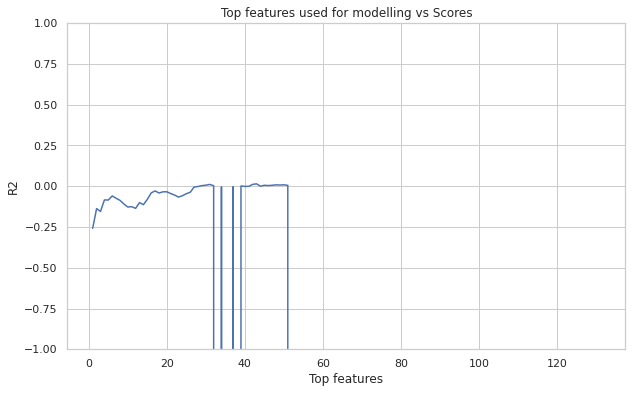

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(top_features, scores)
plt.title('Top features used for modelling vs Scores')
# plt.xlim([0,100])
plt.ylim([-1,1])
plt.xlabel('Top features')
plt.ylabel('R2');

In [48]:
importance_df_selected = importance_df[importance_df['r2 feature importance']>= 0.0001]
# max_score_n_features = scores.index(max(scores))
# importance_df_selected = importance_df.head(max_score_n_features)
print(importance_df_selected.shape)
importance_df_selected

(101, 5)


,feature,r2 feature importance,r2 feature importance std,RMSE feature importance,RMSE feature importance std
96,city_muenchen,0.143019,0.004458,16.32785,0.478756
1,size_sqm,0.129958,0.005353,14.918288,0.58101
93,city_leipzig,0.103137,0.003843,11.977796,0.426167
84,city_dresden,0.076714,0.003907,9.014915,0.443076
106,rental_length_term_<90days,0.028144,0.002106,3.383766,0.249835
...,...,...,...,...,...
26,extras_terrasse,0.000114,0.000121,0.013911,0.014745
65,mobility_street_secondary,0.000113,0.000138,0.013761,0.016788
56,comfort_industrial,0.000112,0.000123,0.013669,0.014972
57,activities_goverment,0.000109,0.000117,0.013268,0.014293


In [49]:
important_features = importance_df_selected.feature.to_list()

# Predictive Power Score

In [50]:
# ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.1.2 which is incompatible.

In [51]:
# A correlation analysis that detects assimetric, also non-linear and numeric plus categorical relationships
# assimetric: ZIP predicts city but the city is a poor predictor of ZIP code
# also non-linear: uses Decision Tree to find relationships that might be linear or not
# numeric plus categorical: finds relationships also in categorical features
# https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598

In [52]:
# pps_matrix = pps.matrix(df_analysed[important_features])

In [53]:
# sns.set_theme(style = "whitegrid", font_scale= 1)
# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 35))

# matrix_df = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
# sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=False, annot_kws={"size": 8});

#  Model parametrization and Learning curves

## Linear Regression

In [54]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']

# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = LinearRegression(n_jobs=-1),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

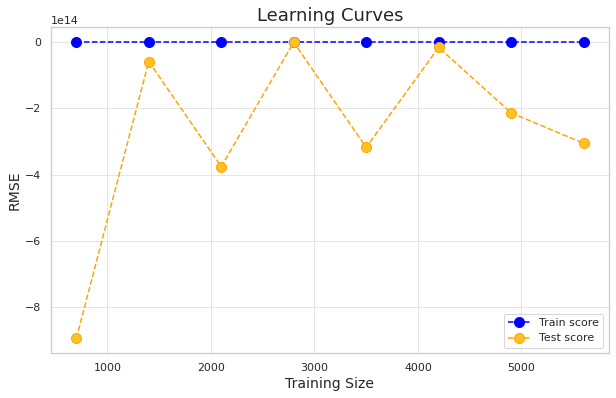

In [55]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Ridge linear Regression

In [56]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']


In [57]:
%%time
# Instanciate model
model = Ridge()

# Hyperparameter search space
search_space = {
    'alpha': [0.1,1,10,100,1000],
    'tol': [0, 0.001,0.1,1],
    'solver': ['lsqr']# auto, 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

# Instanciate GridSearchCV
ridge_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


ridge_rsearch.fit(X,y)
print(ridge_rsearch.best_params_)

{'alpha': 100, 'solver': 'lsqr', 'tol': 0.001}
CPU times: user 254 ms, sys: 118 ms, total: 372 ms
Wall time: 1.41 s


In [58]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = Ridge(alpha = ridge_rsearch.best_params_['alpha'],
                                                                          tol = ridge_rsearch.best_params_['tol'],
                                                                          solver = ridge_rsearch.best_params_['solver']),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

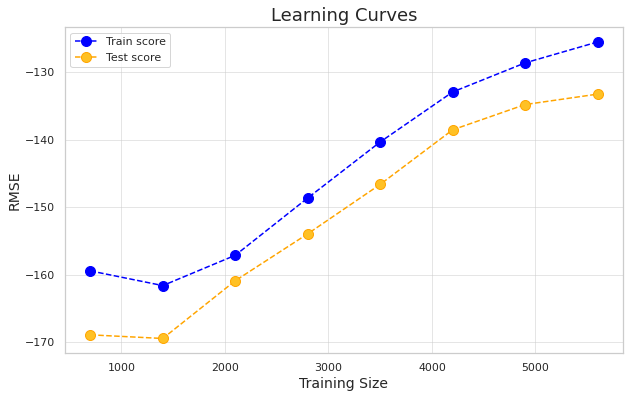

In [59]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Lasso linear Regression

In [60]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']

In [61]:
%%time
# Instanciate model
model = Lasso()

# Hyperparameter search space
search_space = {
    'alpha': [0.1,1,10,100,1000],
    'tol': [0.1,1,10,100,1000],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
lasso_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


lasso_rsearch.fit(X,y)
print(lasso_rsearch.best_params_)

{'alpha': 1, 'selection': 'cyclic', 'tol': 10}
CPU times: user 443 ms, sys: 89.4 ms, total: 533 ms
Wall time: 1.35 s


In [62]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']

# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = Lasso(alpha = lasso_rsearch.best_params_['alpha'],
                                                                          tol = lasso_rsearch.best_params_['tol'],
                                                                          selection = lasso_rsearch.best_params_['selection']),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

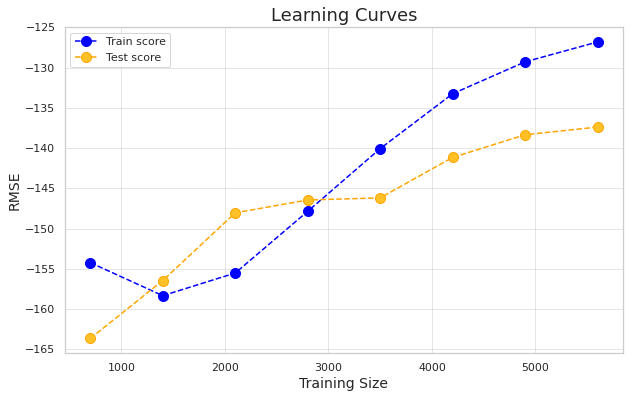

In [63]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## ElasticNet linear Regression

In [64]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']

In [65]:
%%time
# Instanciate model
model = ElasticNet()

# Hyperparameter search space
search_space = {
    'alpha': [0.01,0.1,1,10,100],
    'tol': [0.1,1,10,100],
    'l1_ratio': [0,0.3,0.6,1],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
elastic_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


elastic_rsearch.fit(X,y)
print(elastic_rsearch.best_params_)

{'alpha': 0.01, 'l1_ratio': 0, 'selection': 'cyclic', 'tol': 10}
CPU times: user 1.18 s, sys: 106 ms, total: 1.29 s
Wall time: 15.4 s


In [66]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']

# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = ElasticNet(alpha = elastic_rsearch.best_params_['alpha'],
                                                                               l1_ratio = elastic_rsearch.best_params_['l1_ratio'],
                                                                          tol = elastic_rsearch.best_params_['tol'],
                                                                          selection = elastic_rsearch.best_params_['selection']),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

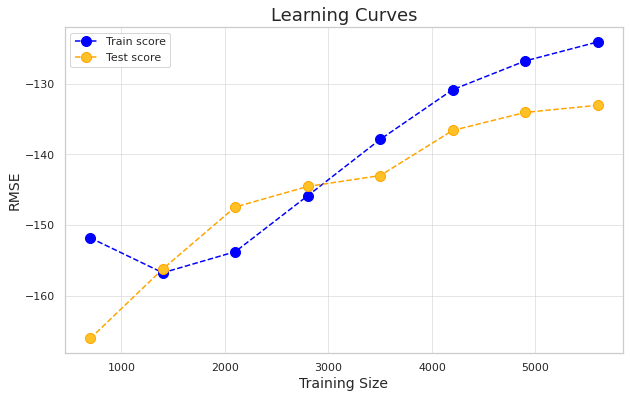

In [67]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Stochastic Gradient Descend

In [68]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']

In [69]:
%%time
# Instanciate model
model = SGDRegressor()

# Hyperparameter search space
search_space = {
    'loss':['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': [0.01,0.1,1],
    'penalty': ['elasticnet'],#['l1','l2','elasticnet'],
    'tol': [1,10,100],
    'l1_ratio': [0,0.3,0.6,1],
    'epsilon': [10,100,1000],
    'learning_rate': ['invscaling'],#,'constant','optimal','adaptive'],
    'eta0': [0.1], 
    'power_t': [0.25],
    'early_stopping': [True]
}

# Instanciate GridSearchCV
sgdr_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


sgdr_rsearch.fit(X,y)
print(sgdr_rsearch.best_params_)

{'alpha': 0.01, 'early_stopping': True, 'epsilon': 100, 'eta0': 0.1, 'l1_ratio': 1, 'learning_rate': 'invscaling', 'loss': 'huber', 'penalty': 'elasticnet', 'power_t': 0.25, 'tol': 100}
CPU times: user 2.41 s, sys: 413 ms, total: 2.82 s
Wall time: 18.9 s


In [70]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']

# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = SGDRegressor(loss=sgdr_rsearch.best_params_['loss'],
                                                                                 penalty=sgdr_rsearch.best_params_['penalty'],
                                                                                 alpha=sgdr_rsearch.best_params_['alpha'],
                                                                                 l1_ratio=sgdr_rsearch.best_params_['l1_ratio'],
                                                                                 fit_intercept=True,
                                                                                 max_iter=1000,
                                                                                 tol=sgdr_rsearch.best_params_['tol'], 
                                                                                 shuffle=True, 
                                                                                 verbose=0, 
                                                                                 epsilon=sgdr_rsearch.best_params_['epsilon'], 
                                                                                 random_state=None, 
                                                                                 learning_rate=sgdr_rsearch.best_params_['learning_rate'],
                                                                                 eta0=sgdr_rsearch.best_params_['eta0'], 
                                                                                 power_t=sgdr_rsearch.best_params_['power_t'], 
                                                                                 early_stopping=sgdr_rsearch.best_params_['early_stopping'], 
                                                                                 validation_fraction=0.1,
                                                                                 n_iter_no_change=5,
                                                                                 warm_start=False, 
                                                                                 average=False),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

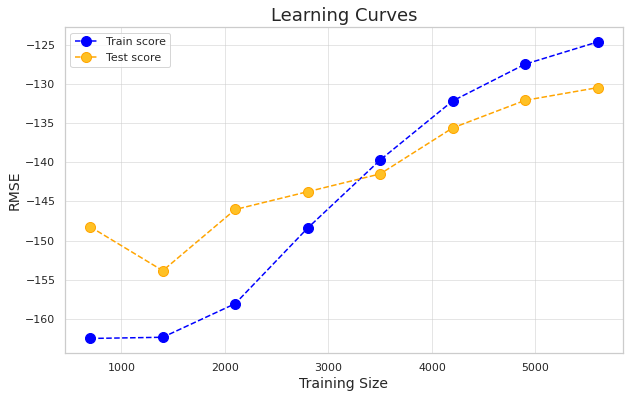

In [71]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## KNN Regressor

In [72]:
%%time
# Instanciate model
model = KNeighborsRegressor(n_jobs=-1)

# Hyperparameter search space
search_space = {
    'n_neighbors': range(5,50,5),
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(10,40,10)
}

# Instanciate GridSearchCV
knn_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


knn_rsearch.fit(X,y)
print(knn_rsearch.best_params_)

{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_neighbors': 20, 'weights': 'distance'}
CPU times: user 2.35 s, sys: 341 ms, total: 2.69 s
Wall time: 3min 34s


In [73]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']

# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = KNeighborsRegressor(n_neighbors=knn_rsearch.best_params_['n_neighbors'],
                                                                                       weights=knn_rsearch.best_params_['weights'],
                                                                                       algorithm=knn_rsearch.best_params_['algorithm'],
                                                                                       leaf_size=knn_rsearch.best_params_['leaf_size']),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

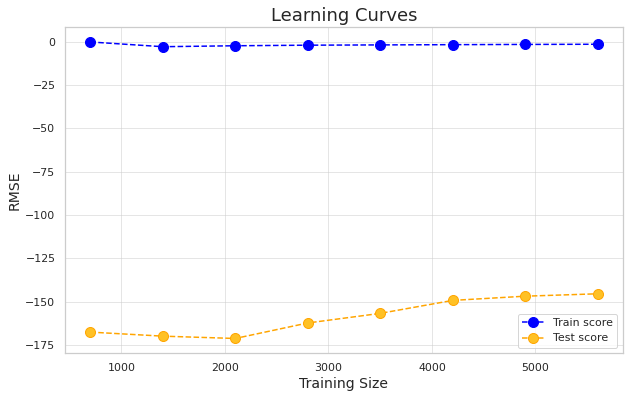

In [74]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Support Vector Machine

In [75]:
%%time
# Instanciate model
model = SVR()

# Hyperparameter search space
search_space = {
    'kernel': ['rbf'],#['linear','poly','sigmoid', 'rbf'],
    'degree': [2,3],
    'C': [500],#[10,100,1000],
    'tol': [0.001,0.01,0.1],
    'gamma': [0.1],#[0,0.1,1,'scale','auto'],
    'coef0': [0],#[0,0.1,1],
    'epsilon': [0.1,1,10]
}

# Instanciate GridSearchCV
svm_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


svm_rsearch.fit(X,y)
print(svm_rsearch.best_params_)

{'C': 500, 'coef0': 0, 'degree': 2, 'epsilon': 10, 'gamma': 0.1, 'kernel': 'rbf', 'tol': 0.1}
CPU times: user 4.58 s, sys: 62.3 ms, total: 4.64 s
Wall time: 2min 35s


In [76]:
X = df_analysed.drop(columns=['price_euros'])
X = df_analysed[important_features]
y = df_analysed['price_euros']

# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = SVR(kernel=svm_rsearch.best_params_['kernel'],
                                                                        degree=svm_rsearch.best_params_['degree'],
                                                                        gamma=svm_rsearch.best_params_['gamma'], 
                                                                        coef0=svm_rsearch.best_params_['coef0'], 
                                                                        tol=svm_rsearch.best_params_['tol'],
                                                                        C=svm_rsearch.best_params_['C'], 
                                                                        epsilon=svm_rsearch.best_params_['epsilon'], 
                                                                        shrinking=True,
                                                                        cache_size=200,
                                                                        verbose=False,
                                                                        max_iter=-1),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

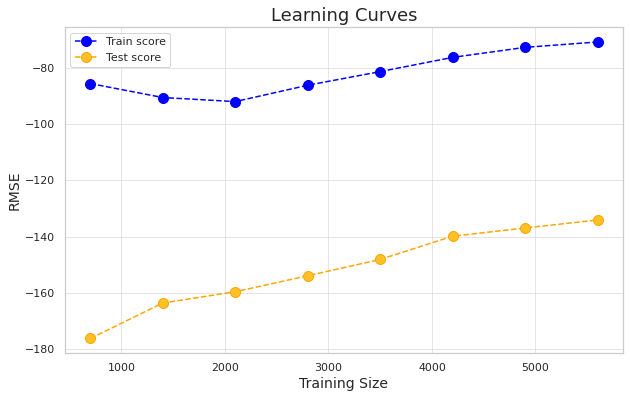

In [77]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

# Building model

In [78]:
## After all this analysis, the linearRegression model seems to outperform all other models....
## Also, analysis of the learning curves indicate that the model training is not yet saturated by number of data points, so I'd use as many as possible for training


In [88]:
X = df_analysed[important_features]
# X = df_analysed.drop(columns=['price_euros'])

## Predicting the log of the prices instead of the prices directly improves prediction slightly
y = np.log2(df_analysed['price_euros'])

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# INSTANTIATING THE MODEL
model = LinearRegression(n_jobs=-1)

# model = Ridge(alpha = ridge_rsearch.best_params_['alpha'],
#               tol = ridge_rsearch.best_params_['tol'],
#               solver = ridge_rsearch.best_params_['solver'])

# model = Lasso(alpha = lasso_rsearch.best_params_['alpha'],
#               tol = lasso_rsearch.best_params_['tol'],
#               selection = lasso_rsearch.best_params_['selection'])

# model = ElasticNet(alpha = elastic_rsearch.best_params_['alpha'],
#                     l1_ratio = elastic_rsearch.best_params_['l1_ratio'],
#                     tol = elastic_rsearch.best_params_['tol'],
#                     selection = elastic_rsearch.best_params_['selection'])

# model = SGDRegressor(loss=sgdr_rsearch.best_params_['loss'],
#                      penalty=sgdr_rsearch.best_params_['penalty'],
#                      alpha=sgdr_rsearch.best_params_['alpha'],
#                      l1_ratio=sgdr_rsearch.best_params_['l1_ratio'],
#                      fit_intercept=True,
#                      max_iter=1000,
#                      tol=sgdr_rsearch.best_params_['tol'], 
#                      shuffle=True, 
#                      verbose=0, 
#                      epsilon=sgdr_rsearch.best_params_['epsilon'], 
#                      random_state=None, 
#                      learning_rate=sgdr_rsearch.best_params_['learning_rate'],
#                      eta0=sgdr_rsearch.best_params_['eta0'], 
#                      power_t=sgdr_rsearch.best_params_['power_t'], 
#                      early_stopping=sgdr_rsearch.best_params_['early_stopping'], 
#                      validation_fraction=0.1,
#                      n_iter_no_change=5,
#                      warm_start=False, 
#                      average=False)

# model = KNeighborsRegressor(n_neighbors=knn_rsearch.best_params_['n_neighbors'],
#                             weights=knn_rsearch.best_params_['weights'],
#                             algorithm=knn_rsearch.best_params_['algorithm'],
#                             leaf_size=knn_rsearch.best_params_['leaf_size'])

# model = SVR(kernel=svm_rsearch.best_params_['kernel'],
#             degree=svm_rsearch.best_params_['degree'],
#             gamma=svm_rsearch.best_params_['gamma'],
#             coef0=svm_rsearch.best_params_['coef0'], 
#             tol=svm_rsearch.best_params_['tol'], 
#             C=svm_rsearch.best_params_['C'], 
#             epsilon=svm_rsearch.best_params_['epsilon'], 
#             shrinking=True,
#             cache_size=200,
#             verbose=False,
#             max_iter=-1)

# TRAINING THE MODEL ON THE TRAINING SET
model.fit(X_train,y_train)

# EVALUATION
model.score(X_test, y_test)

0.5335086488538896

In [89]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [90]:
regression_results(y_true = 2**y_test, y_pred = 2**model.predict(X_test))

explained_variance:  0.5369
mean_squared_log_error:  0.0552
r2:  0.5294
MAE:  83.343
MSE:  14349.9836
RMSE:  119.7914


RMSE: 119.791416908612
RMSE base model (mean value): 176.82157016903284


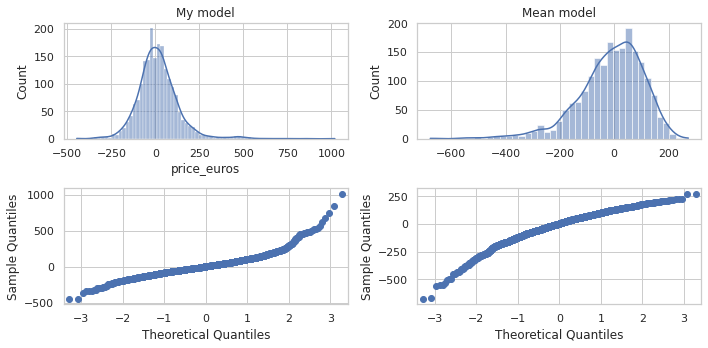

In [91]:
import statsmodels.api as sm

y_pred = 2**model.predict(X_test)
y_base = [2**np.mean(y)]*len(y_pred)
y_true = 2**y_test

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model (mean value): {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(y_pred)
residuals = y_true - y_pred
residuals_base = y_base - y_pred

# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1).set(title='My model')
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2).set(title='Mean model')

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(residuals, ax=ax3)
sm.qqplot(residuals_base, ax=ax4)
plt.tight_layout()
fig.show();

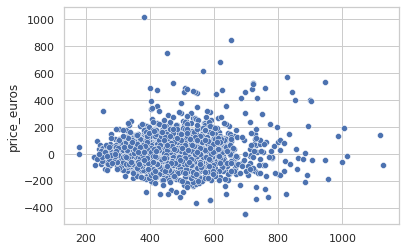

In [92]:
sns.scatterplot(x=y_pred, y=residuals);